In [149]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import textblob
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [150]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Text Preprocessing

In [108]:
df = pd.read_csv("amazon_reviews.csv")

In [109]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


# Dataset ini berisi ulasan produk dari Amazon, mencakup berbagai kategori dan tahun.

## Atribut:

ReviewerID: Identifikasi unik dari pengulas

ProductID (asin): Identifikasi unik dari produk

ReviewerName: Nama pengulas

ReviewText: Teks ulasan

Overall: Peringkat yang diberikan oleh pengulas

Summary: Ringkasan singkat dari ulasan

UnixReviewTime: Waktu ulasan dalam format UNIX

ReviewTime: Waktu ulasan dalam format yang mudah dibaca manusia

Helpful: Suara untuk ulasan yang dianggap membantu [helpful_yes, total_vote]

Day_diff: Jumlah hari antara waktu ulasan dan waktu referensi tertentu

Helpful_yes: Jumlah suara yang menyatakan ulasan tersebut membantu

Total_vote: Jumlah total suara untuk ulasan tersebut

## Tujuan: Melakukan analisis sentimen dan pemodelan sentimen pada teks ulasan untuk memahami preferensi dan tingkat kepuasan pelanggan.

# Normalizing Case Folding
semua teks pada kolom 'reviewText' diubah menjadi huruf kecil (lowercase). Standarisasi ini bertujuan untuk memastikan konsistensi dalam dataset dengan menghilangkan variasi yang disebabkan oleh perbedaan huruf kapital. Hal ini membantu meningkatkan efektivitas proses pemrosesan teks selanjutnya, seperti tokenisasi, penghapusan stopword, dan analisis sentimen.

In [110]:
df['reviewText']

0                                              No issues.
1       Purchased this for my device, it worked as adv...
2       it works as expected. I should have sprung for...
3       This think has worked out great.Had a diff. br...
4       Bought it with Retail Packaging, arrived legit...
                              ...                        
4910    I bought this Sandisk 16GB Class 10 to use wit...
4911    Used this for extending the capabilities of my...
4912    Great card that is very fast and reliable. It ...
4913    Good amount of space for the stuff I want to d...
4914    I've heard bad things about this 64gb Micro SD...
Name: reviewText, Length: 4915, dtype: object

In [111]:
df['reviewText'] = df['reviewText'].str.lower()

In [152]:
df['reviewText']

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used capability samsung galaxy note greatly ex...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

# Punctuations

Pada langkah ini, kami menghapus tanda baca dari komentar pada kolom 'reviewText'. Proses ini bertujuan untuk meningkatkan efisiensi tugas pemrosesan bahasa dengan membuat data teks menjadi lebih bersih dan lebih sesuai untuk dianalisis.

In [113]:
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '', regex=True)

In [153]:
df['reviewText']

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used capability samsung galaxy note greatly ex...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

# Numbers

Pada langkah ini, kami menghapus karakter angka dari komentar pada kolom 'reviewText'. Dengan menghilangkan angka dari teks, proses ini memungkinkan kami untuk lebih fokus pada tugas pemrosesan bahasa dan analisis teks. Dengan demikian, kami dapat berkonsentrasi sepenuhnya pada konten teks, sehingga analisis data menjadi lebih bersih dan bermakna.

In [115]:
df['reviewText'] = df['reviewText'].str.replace('\d', '', regex=True)

In [154]:
df['reviewText']

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used capability samsung galaxy note greatly ex...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

# Stopwords

Pada bagian ini, dengan menghapus kata-kata yang sering muncul dan cenderung tidak memiliki makna penting (seperti 'the', 'is', 'in') dari teks, kita dapat memfokuskan analisis pada kata-kata yang lebih bermakna. Hal ini memungkinkan kita untuk lebih memahami inti dari komentar serta membuat proses NLP menjadi lebih efisien.

In [117]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ammar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ammar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [118]:
sw = stopwords.words('english')

In [119]:
sw

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [120]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [155]:
df['reviewText']

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used capability samsung galaxy note greatly ex...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

# Rarewords

Pada langkah ini, pertama-tama kami menggabungkan semua komentar dalam kolom 'reviewText', kemudian memecah teks hasil gabungan tersebut menjadi kata-kata dan menghitung frekuensi kemunculan setiap kata. Dari proses ini, kami mengidentifikasi kata-kata yang hanya muncul satu kali. Selanjutnya, kata-kata yang jarang digunakan ini dihapus dari komentar pada kolom 'reviewText'. Proses ini membantu menghilangkan kata-kata yang memiliki bobot semantik dan frekuensi rendah dalam teks, sehingga analisis dapat lebih difokuskan pada kata-kata yang lebih signifikan.

In [122]:
temp_df = pd.Series(' '.join(df['reviewText']).split()).value_counts()

In [123]:
temp_df

card                4603
gb                  1725
phone               1685
works               1559
great               1445
                    ... 
nitpicky               1
unexpectedlythen       1
gpe                    1
gpad                   1
prepard                1
Name: count, Length: 9701, dtype: int64

In [124]:
drops = temp_df[temp_df <= 1]

In [125]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [126]:
df['reviewText']

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected higher capacity think made bit ...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used capabilities samsung galaxy note greatly ...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewText, Length: 4915, dtype: object

In [127]:
temp_df_1 = pd.Series(' '.join(df['reviewText']).split()).value_counts()

In [156]:
temp_df_1

card            4603
gb              1725
phone           1685
works           1559
great           1445
                ... 
fue                2
batches            2
warehouses         2
overuse            2
hpusbdiskexe       2
Name: count, Length: 4089, dtype: int64

# Tokenization

Pada bagian ini, setiap komentar dalam kolom 'reviewText' diubah menjadi objek TextBlob dan kemudian ditokenisasi menjadi kata-kata. TextBlob memungkinkan kita untuk dengan mudah membagi komentar menjadi token (kata) yang dapat diproses. Proses ini memungkinkan kita untuk menelaah setiap kata dalam komentar secara individual dan melakukan analisis yang lebih mendetail berdasarkan kata-kata tersebut.

In [157]:
df["reviewText"].apply(lambda x: TextBlob(x).words).head()

0                                              [issue]
1    [purchased, device, worked, advertised, never,...
2    [work, expected, higher, capacity, think, made...
3    [think, worked, gb, card, went, south, one, he...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewText, dtype: object

# Lemmatization

Pada langkah ini, setiap kata dalam komentar pada kolom 'reviewText' dilematisasi untuk mendapatkan bentuk dasarnya. Lemmatization mengubah berbagai bentuk infleksi kata (seperti 'running' menjadi 'run') ke bentuk dasar. Proses ini memberikan kesempatan pemrosesan data yang lebih konsisten dan bermakna dalam analisis yang kami lakukan.

In [130]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ammar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [131]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ammar\AppData\Roaming\nltk_data...


True

In [132]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [158]:
df['reviewText']

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used capability samsung galaxy note greatly ex...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

# Text Visualization

## Calculation of Term Frequencies

Pada langkah ini, kami menghitung frekuensi kemunculan kata (tf, atau term frequency) dari semua kata dalam komentar pada kolom 'reviewText'. Kami memisahkan kata-kata dalam setiap komentar, menentukan berapa kali setiap kata muncul dalam komentar tersebut, dan menjumlahkan angka-angka tersebut. Selanjutnya, frekuensi ini diubah menjadi sebuah DataFrame dengan kolom 'words' dan 'tf'. Terakhir, DataFrame ini diurutkan secara menurun berdasarkan nilai 'tf'. Proses ini membantu kami mengidentifikasi kata-kata yang paling sering digunakan dalam komentar serta tingkat kemunculannya, sehingga memungkinkan kami untuk memvisualisasikan dan menganalisis istilah-istilah paling signifikan dalam dataset.

In [134]:
tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [135]:
tf.columns = ['words', 'tf']

In [136]:
tf_sorted = tf.sort_values(by='tf', ascending=False)

In [159]:
tf_sorted

,words,tf
27,card,5537.00
14,work,2044.00
7,phone,1909.00
28,gb,1756.00
91,great,1445.00
...,...,...
3653,recommemd,2.00
3652,nowhere,2.00
3651,ultrabook,2.00
3650,fluke,2.00


# Barplot

Pada langkah ini, berdasarkan frekuensi kata (tf) yang telah dihitung sebelumnya, kami memfilter kata-kata dengan frekuensi lebih dari 500. Selanjutnya, kami memvisualisasikan frekuensi kata-kata tersebut menggunakan grafik batang. Sumbu-x pada grafik mewakili kata-kata, sedangkan sumbu-y menunjukkan total kemunculan kata-kata tersebut dalam komentar (tf). Visualisasi ini dengan jelas menampilkan kata-kata yang paling sering muncul dalam dataset kami beserta tingkat kemunculannya, sehingga memungkinkan kami untuk lebih memahami tren dan pola utama dalam data teks.

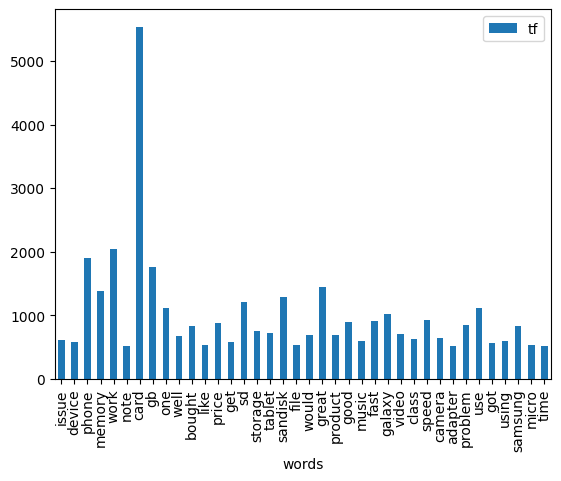

In [160]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show(block=True)

# Word Cloud

Pada bagian ini, kami membuat dan memvisualisasikan word cloud menggunakan komentar dari kolom 'reviewText'. Tujuannya adalah untuk menampilkan kata-kata yang sering muncul dalam dataset dalam bentuk visual, sehingga dengan jelas memperlihatkan pentingnya dan tingkat kemunculan kata-kata tersebut dalam komentar. Hal ini memungkinkan pengamatan cepat terhadap tren utama dan fitur-fitur menonjol dalam data teks.

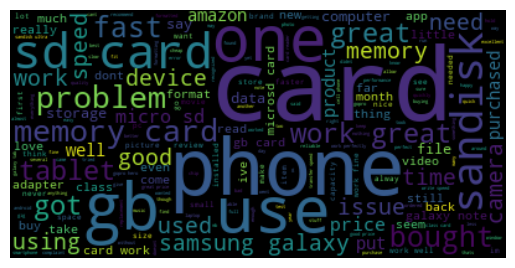

In [161]:
text = " ".join(i for i in df.reviewText)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment Analysis

Pada bagian ini, kami akan melakukan analisis sentimen pada data teks kami. Kami akan mengevaluasi ekspresi emosional dalam teks menggunakan metode matematis untuk menentukan apakah teks-teks tersebut secara umum mengandung sentimen positif, negatif, atau netral. Hal ini memungkinkan kami menyatakan sentimen teks dalam bentuk nilai numerik, sehingga analisis menjadi lebih objektif dan terukur.

In [140]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ammar\AppData\Roaming\nltk_data...


True

In [141]:
df["reviewText"].head()

0                                                issue
1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked gb card went south one held prett...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

In [142]:
sia = SentimentIntensityAnalyzer()

In [143]:
sia.polarity_scores("The film was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [144]:
sia.polarity_scores("I liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [145]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...
3    {'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'comp...
4    {'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.108, 'neu': 0.598, 'pos': 0.295, 'co...
7    {'neg': 0.077, 'neu': 0.65, 'pos': 0.272, 'com...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.457, 'pos': 0.543, 'comp...
Name: reviewText, dtype: object

In [146]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.00
1   0.00
2   0.40
3   0.65
4   0.86
5   0.00
6   0.87
7   0.82
8   0.00
9   0.92
Name: reviewText, dtype: float64

In [147]:
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [162]:
df.head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86
5,A2IDCSC6NVONIZ,B007WTAJTO,2Cents!,"[0, 0]",mini storage doesnt anything else supposed pur...,5.00,Not a lot to really be said,1367193600,2013-04-29,588,0,0,0.00
6,A26YHXZD5UFPVQ,B007WTAJTO,2K1Toaster,"[0, 0]",phone never skip beat file transfer speedy cor...,5.00,Works well,1382140800,2013-10-19,415,0,0,0.87
7,A3CW0ZLUO5X2B1,B007WTAJTO,"35-year Technology Consumer ""8-tracks to 802.11""","[0, 0]",hard believe affordable digital become gb devi...,5.00,32 GB for less than two sawbucks...what's not ...,1404950400,2014-10-07,62,0,0,0.82
8,A2CYJO155QP33S,B007WTAJTO,4evryoung,"[1, 1]",work htc rezound running short space gb sandis...,5.00,Loads of room,1395619200,2014-03-24,259,1,1,0.00
9,A2S7XG3ZC4VGOQ,B007WTAJTO,53rdcard,"[0, 0]",galaxy super fast card totally happy happy sti...,5.00,works great,1381449600,2013-11-10,393,0,0,0.92


# Feature Engineering

Pada bagian ini, analisis sentimen dilakukan untuk menentukan nada emosional dari teks-teks tersebut, dan setiap komentar diberi label sebagai 'positif' (pos) atau 'negatif' (neg) berdasarkan skor sentimen gabungan (compound sentiment score)-nya. Selanjutnya, kita memeriksa distribusi label sentimen ini dalam dataset serta hubungannya dengan skor rating keseluruhan. Terakhir, label sentimen ini diubah menjadi nilai numerik untuk digunakan dalam model pembelajaran mesin. Langkah-langkah ini membantu kita mengekstrak fitur yang bermakna dari data teks, sehingga siap untuk tahap analisis dan pemodelan selanjutnya.

In [163]:
df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    neg
1    neg
2    pos
3    pos
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: reviewText, dtype: object

In [164]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [165]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00,neg
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00,neg
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40,pos
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65,pos
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86,pos


In [166]:
df["sentiment_label"].value_counts()

sentiment_label
pos    3944
neg     971
Name: count, dtype: int64

In [167]:
df.groupby("sentiment_label")["overall"].mean()

sentiment_label
neg   4.09
pos   4.71
Name: overall, dtype: float64

In [168]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [169]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40,1
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65,1
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86,1


In [170]:
y = df["sentiment_label"] # dependent variable

In [171]:
X = df["reviewText"] # independent variable

# Count Vectors

Pada bagian ini, teks-teks dalam kolom 'reviewText' diubah menjadi vektor numerik menggunakan metode CountVectorizer. Selama proses transformasi ini, frekuensi setiap kata dalam teks dihitung, dan frekuensi tersebut digunakan untuk mengonversi setiap teks menjadi vektor numerik. Langkah ini sangat penting untuk mengubah data teks menjadi format yang sesuai agar dapat digunakan dalam model pembelajaran mesin. Representasi numerik dari teks ini memudahkan ekstraksi fitur-fitur penting dan pemrosesan data yang efisien selama proses pemodelan.

## Word Frequency

In [172]:
vectorizer = CountVectorizer()

In [173]:
X_count = vectorizer.fit_transform(X)

In [174]:
vectorizer.get_feature_names_out()[10:15]

array(['access', 'accessed', 'accessible', 'accessing', 'accessory'],
      dtype=object)

In [175]:
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(5, 3668))

## N-Gram Frequency

In [176]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))

In [177]:
X_n = vectorizer2.fit_transform(X)

In [178]:
vectorizer2.get_feature_names_out()[10:15]

array(['ability put', 'ability sandisk', 'ability something',
       'ability stick', 'ability store'], dtype=object)

In [179]:
X_n.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(4915, 62323))

## TF-IDF

In [180]:
tf_idf_word_vectorizer = TfidfVectorizer()

In [181]:
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [182]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))

In [183]:
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

# Sentiment Modeling

## Logistic Regression

In [184]:
log_model = LogisticRegression().fit(X_tf_idf_word, y)

In [185]:
cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()

np.float64(0.830111902339776)

In [186]:
new_review = pd.Series("this product is great")

In [187]:
new_review = pd.Series("look at that shit very bad")

In [188]:
new_review = pd.Series("it was good but I am sure that it fits me")

In [189]:
new_review = TfidfVectorizer().fit(X).transform(new_review)

In [190]:
log_model.predict(new_review)

array([1])

In [191]:
random_review = pd.Series(df["reviewText"].sample(1).values)

In [192]:
new_review = TfidfVectorizer().fit(X).transform(random_review)

In [193]:
log_model.predict(new_review)

array([1])